In [1]:
from xflowrl.util.util import plot_to_image, plot_xfer_heatmap
from collections import OrderedDict
import seaborn as sns
import json
import pandas as pd

/home/sean/.pyenv/versions/3.7.0/envs/xflow/lib/python3.7/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [5]:
xfers_applied = {'100': 10, '90': 30, '3': 5, '60': 15}
print({'xfer': [int(k) for k in xfers_applied.keys()], 'count': [v for _, v in xfers_applied.items()] })
xfers_applied_1 = {'xfer': [100, 67, 9, 151], 'count': [10, 15, 5, 7]}

{'xfer': [100, 90, 3, 60], 'count': [10, 30, 5, 15]}


   xfer  count
0   100     10
1    67     15
2     9      5
3   151      7


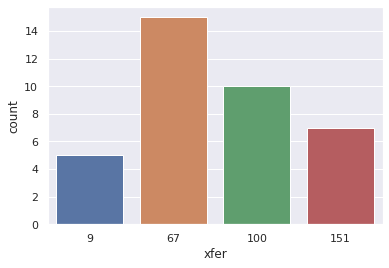

In [3]:
fig = plot_xfer_heatmap(xfers_applied)

In [21]:
def plot_pair_grid(graph, timestamp):
    data = dict(runtime=[], flops=[], mem_acc=[], num_kernels=[], graph=[])
    
    if not isinstance(graph, list):
        graph = [graph]
    if not isinstance(timestamp, list):
        timestamp = [timestamp]
    
    
    for i, _ in enumerate(graph):
        path = f'../logs/xflowrl/{graph[i]}/{timestamp[i]}/runtime_info.json'
        with open(path, 'r', encoding='utf-8') as f:
            detailed_costs = json.load(f)

        for e in detailed_costs:
            for k, v in e.items():
                data[k].append(v)
        data['graph'].extend([graph[i]] * len(detailed_costs))

    df = pd.DataFrame.from_dict(data)

    g = sns.PairGrid(df, hue='graph')
    g.map_diag(sns.histplot)
    g.map_offdiag(sns.scatterplot)
    g.add_legend()

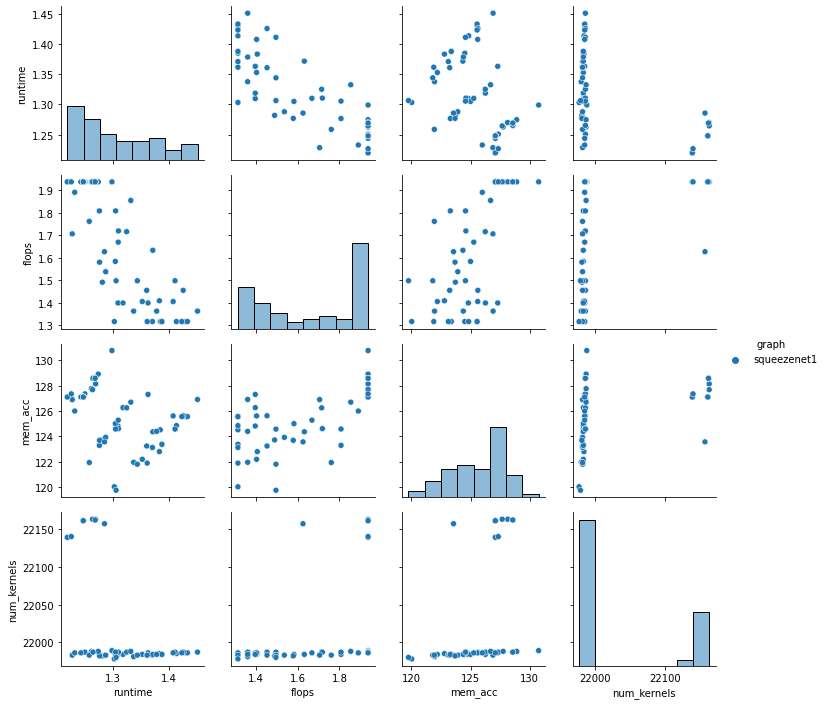

In [22]:
#graphs = ['BERT', 'squeezenet1']
#timestamps = ['20210309-161428', '20210311-184605']
#plot_pair_grid(graphs, timestamps)

plot_pair_grid('squeezenet1', '20210311-184605')